# Cardiac Interoception Analysis and Results

## Overview

This notebook analyzes quantitative and qualitative data from preliminary heartbeat tracking experiments for participant MW. They are part of a larger series of interoception studies designed to learn more about the interoceptive profile of MW across a variety of tasks and internal physiological processes. They aim to get a rough sense of how reliably MW can report on the dynamics of various types of internal states. 

We’re asking: How much can we trust what she reports about somatic perceptual experience X? Does she know when her reports are more or less accurate? And does this reliability vary by system?

## Introduction
Interoception is the sense of internal bodily signals like heartbeat and respiration. It underpins emotional awareness, decision-making, and self-perception. To help deal with the nuances and dificulties associated with interoceptive studies, multidimensional models aid interpretation. Three components used by Garfinkel et al., 2015[^1] are: **accuracy** (a measure of objective performance), **awareness** (a metacognitive measure of how well confidence tracks actual performance), and **bias** or sensibility (a measure of tendency to over- or under-estimate confidence). The heartbeat tracking task asks participants to count felt heartbeats over timed intervals. 

## Objectives
These sessions serve the following purposes:
1. Experimental Validation - Pilot the heartbeat tracking procedure and refine experimental variables such as posture, timing, interface, and instructions.
2. Baseline Profiling - Begin characterizing MW’s interoceptive profile (accuracy, resolution, awareness, bias, etc. for various physiological processes/tasks)
3. Qualitative-Quantitative Alignment - Assess whether narrative reports of interoceptive experience reflect the same patterns as quantitative measures. This includes evaluating (the consistency between subjective narratives and confidence/accuracy data, the potential for AI-based models to extract meaningful features from narrative data, the broader role of narrative as a complementary dimension in multimodal interoceptive analysis)

*Note: Supplementary material is available at the end of this notesbook including experimental protocols, etc.*

## Setup and Data Cleaning/Prep

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import json
import openai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from dotenv import load_dotenv

from helpers.base_imports import *

In [3]:
# Load environment variables
load_dotenv()
api_key = os.getenv("OPEN_ROUTER_API_KEY")

In [4]:
# Load experimental data from data/ folder and put into dataframe
df = pd.read_csv("data/preliminary-experiments - heartbeat-tracking.csv")

In [5]:
display(df.head(5))
print(df.shape)
print(df.columns)

,Experiment Name,Procedure,Experimenter ID,Participant ID,Measurement Method,Additional Materials Used,Date,Time (EST),Prepatory Period (min),Participant Posture,Duration (s),Participant Count,Experimenter Count,Participant Confidence,Participant Story,Experimenter Story,Notes
0,Heartbeat Tracking,NaN,RC,MW,stethoscope on chest,blindfold,6/10/2025,10:10,4,supine,20,16,19,M,NaN,NaN,slow start.E finger cramping from position
1,Heartbeat Tracking,NaN,RC,MW,Stethoscope on chest,blindfold,6/10/2025,10:21,0,sitting,30,23,29,L,NaN,NaN,"phb didn""t feel strong"
2,Heartbeat Tracking,NaN,RC,MW,Stethoscope on chest,blindfold,6/10/2025,10:27,1,supine,15,14,14,M,NaN,NaN,NaN
3,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/10/2025,11:49,4,sitting,20,11,20,L,NaN,NaN,p couldn't differentiate hb from other sensations
4,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/11/2025,10:04,2,supine,20,19,24,M,NaN,NaN,p may have started counting at 4 instead on 1


(43, 17)
Index(['Experiment Name', 'Procedure', 'Experimenter ID', 'Participant ID',
       'Measurement Method', 'Additional Materials Used', 'Date', 'Time (EST)',
       'Prepatory Period (min)', 'Participant Posture', 'Duration (s)',
       'Participant Count', 'Experimenter Count', 'Participant Confidence',
       'Participant Story', 'Experimenter Story', 'Notes'],
      dtype='object')


In [6]:
# Clean formatting so we can search for/select specific measurement methods without whitespace/caps/etc issues
df.columns = df.columns.str.strip()
df["Measurement Method"] = df["Measurement Method"].str.lower().str.strip()

In [7]:
# Keep only experiments using the most common measurement method (appears at least 3 times)
method_counts = df["Measurement Method"].value_counts()
valid_methods = method_counts[method_counts > 3].index
print(f"Valid measurement methods (at least 3 occurrences): {valid_methods.tolist()}")
df = df[df["Measurement Method"].isin(valid_methods)].reset_index(drop=True)

Valid measurement methods (at least 3 occurrences): ['fingers on carotid']


In [8]:
# check number of rows should now be 3 less where we tried using the stethoscope instead of the fingers on carotid artery
df.shape

(40, 17)

In [9]:
# Ensure Duration is integer
df["Duration (s)"] = df["Duration (s)"].astype(int)

In [10]:
# Standardize date and experiment index
df["Date"] = df["Date"].astype(str).str.strip()

In [11]:
# change "M to L" to ML for consistency
df["Participant Confidence"] = df["Participant Confidence"].replace({"M to L": "ML"})
print(df["Participant Confidence"].unique())

['L' 'M' 'ML' 'MH' 'H']


In [12]:
# lowercase and strip cols: Additional Materials Used, Participant Posture, Participant Posture
df["Additional Materials Used"] = (
    df["Additional Materials Used"].str.lower().str.strip()
)
df["Participant Posture"] = df["Participant Posture"].str.lower().str.strip()
df["Participant Posture"] = df["Participant Posture"].str.lower().str.strip()

In [13]:
# Add a column for signed count difference (participant - experimenter) - assumes experimenter count is the ground truth
df["Count Difference"] = df["Participant Count"] - df["Experimenter Count"]

In [14]:
# Add a column for accuracy score using count difference
df["Accuracy"] = 1 - (df["Count Difference"].abs() / df["Experimenter Count"])

In [15]:
# Add experiment index per day (i.e. order in which experiments happened)
df["Experiment Index in Day"] = df.groupby("Date").cumcount() + 1

### (Optional) Remove Trials where Experimenter Error is Noted

Since we are considering experimenter count as ground truth, we should drop rows where the experimenter noted anything less than clarity.

In [16]:
# we use GPT to check the experimenter story and identify candidate rows to drop

# gather data to send to GPT (may need to batch if number of rows is too large)
df_subset = df.reset_index(names="index")[["index", "Experimenter Story", "Notes"]]
data_to_send = df_subset.to_dict(orient="records")
data_json = json.dumps(data_to_send)

In [17]:
data_json

'[{"index": 0, "Experimenter Story": NaN, "Notes": "p couldn\'t differentiate hb from other sensations"}, {"index": 1, "Experimenter Story": NaN, "Notes": "p may have started counting at 4 instead on 1"}, {"index": 2, "Experimenter Story": NaN, "Notes": "p not starting and stopping at vwebal ques"}, {"index": 3, "Experimenter Story": "felt strong pulse but was off on counting 1-2", "Notes": "Just ate"}, {"index": 4, "Experimenter Story": "hb was strong than faint. missed some", "Notes": NaN}, {"index": 5, "Experimenter Story": "faint but consistant", "Notes": NaN}, {"index": 6, "Experimenter Story": "strong hb initially then faint, strong again", "Notes": NaN}, {"index": 7, "Experimenter Story": "faint than stronghb", "Notes": NaN}, {"index": 8, "Experimenter Story": "clear and strong", "Notes": NaN}, {"index": 9, "Experimenter Story": "clear and strong", "Notes": NaN}, {"index": 10, "Experimenter Story": "clear and strong", "Notes": NaN}, {"index": 11, "Experimenter Story": "clear and

In [18]:
system_msg = (
    "You are helping clean an experimenter's dataset.\n\n"
    "They have written narrative accounts about each trial.\n\n"
    "Please return the indices of any rows where the experimenter expresses:\n"
    "- low confidence\n"
    "- uncertainty about their own accuracy\n"
    "- doubt in their ability to observe the trial clearly\n\n"
    "Note:\n"
    "- 'p' refers to the participant. So if you see something like 'p was not clear,' that is NOT a reason to flag the row.\n"
    "- You are ONLY flagging cases where the experimenter may have erred or seemed unsure.\n"
)

user_msg = f"Here is the data:\n{data_json}\n\nReturn a Python list of indices for rows to exclude."

In [19]:
import requests
import json

response = requests.get(
    "https://openrouter.ai/api/v1/models",
    headers={"Authorization": f"Bearer {api_key}"},
)

if response.status_code == 200:
    full_data = response.json()
    output_path = "data/openrouter_models.json"

    with open(output_path, "w") as f:
        json.dump(full_data, f, indent=2)

    print(f"Model list saved to: {output_path}")
else:
    print(f"Failed to retrieve models: {response.status_code} - {response.text}")

Model list saved to: data/openrouter_models.json


In [20]:
client = openai.OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
)

In [21]:
completion = client.chat.completions.create(
    model="openai/gpt-4.1-nano",
    messages=[
        {"role": "system", "content": system_msg},
        {"role": "user", "content": user_msg},
    ],
    temperature=0,
)

result = completion.choices[0].message.content.strip()
print(result)

# Optional: attempt to parse the response
try:
    flagged_indices = eval(result)
except Exception as e:
    print("Failed to parse response:", e)
    flagged_indices = []

print("Candidate rows for exclusion:", flagged_indices)

[0, 1, 2, 3, 17, 21, 22, 23, 38]
Candidate rows for exclusion: [0, 1, 2, 3, 17, 21, 22, 23, 38]


In [22]:
# create a column called Experimenter Error and use 0 or 1 to indicate whether the row should be excluded
df["Experimenter Error"] = df.index.isin(flagged_indices).astype(int)

In [23]:
# examine rows flagged for exclusion and drop
df_flagged = df[df["Experimenter Error"] == 1]
print("Flagged rows for exclusion:")
display(df_flagged)

Flagged rows for exclusion:


,Experiment Name,Procedure,Experimenter ID,Participant ID,Measurement Method,Additional Materials Used,Date,Time (EST),Prepatory Period (min),Participant Posture,...,Participant Count,Experimenter Count,Participant Confidence,Participant Story,Experimenter Story,Notes,Count Difference,Accuracy,Experiment Index in Day,Experimenter Error
0,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/10/2025,11:49,4,sitting,...,11,20,L,NaN,NaN,p couldn't differentiate hb from other sensations,-9,0.550000,1,1
1,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/11/2025,10:04,2,supine,...,19,24,M,NaN,NaN,p may have started counting at 4 instead on 1,-5,0.791667,1,1
2,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/11/2025,10:12,0,sitting,...,17,21,M,NaN,NaN,p not starting and stopping at vwebal ques,-4,0.809524,2,1
3,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/18/2025,10:18,2,sitting,...,16,21,ML,it took a few seconds to locate after hearing ...,felt strong pulse but was off on counting 1-2,Just ate,-5,0.761905,1,1
17,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/20/2025,11:45,0,sitting,...,16,17,M,on and off with it,faint than clear,NaN,-1,0.941176,6,1
21,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/20/2025,11:53,0,supine,...,27,25,M,NaN,i may have missed 1-2 at start with saying rea...,NaN,2,0.920000,10,1
22,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/20/2025,11:58,0,sitting,...,19,22,L,focus distracted by dog bark,faint,NaN,-3,0.863636,11,1
23,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/20/2025,12:00,0,sitting,...,23,23,M,i lost it in the middle,faint,NaN,0,1.000000,12,1
38,Heartbeat Tracking,NaN,RC,MW,fingers on carotid,blindfold,6/23/2025,10:54,0,sitting,...,21,24,L,I wan distracted for half of the time,faint and felt like I lost it dor a bit. I als...,NaN,-3,0.875000,13,1


Human review suggests that keeping flag recomendations for: 3, 21, 38...the rest are should be unflagged

In [24]:
# flag these but uflag all the rest
human_reviewed_flagged_indices = [3, 21, 38]
df["Experimenter Error"] = 0
df.loc[df.index.isin(human_reviewed_flagged_indices), "Experimenter Error"] = 1

In [25]:
display(df[["Experimenter Error", "Participant Story", "Experimenter Story", "Notes"]])

,Experimenter Error,Participant Story,Experimenter Story,Notes
0,0,NaN,NaN,p couldn't differentiate hb from other sensations
1,0,NaN,NaN,p may have started counting at 4 instead on 1
2,0,NaN,NaN,p not starting and stopping at vwebal ques
3,1,it took a few seconds to locate after hearing ...,felt strong pulse but was off on counting 1-2,Just ate
4,0,id feel we are starting at the same time but i...,hb was strong than faint. missed some,NaN
5,0,faint hb with everything else going on in body...,faint but consistant,NaN
6,0,i felt like the first half on it then grew fai...,"strong hb initially then faint, strong again",NaN
7,0,got distracted a couple of times. I had more p...,faint than stronghb,NaN
8,0,ik i felt it clearly but started on the wrong ...,clear and strong,NaN
9,0,still not absolutely sure what i'm feeling is ...,clear and strong,NaN


In [26]:
# drop flagged rows
print(f"Dataset shape before dropping experimenter errors: {df.shape}")
df_cleaned = df[df["Experimenter Error"] == 0].reset_index(drop=True)
print(f"Dataset shape after dropping experimenter errors: {df_cleaned.shape}")

Dataset shape before dropping experimenter errors: (40, 21)
Dataset shape after dropping experimenter errors: (37, 21)


In [ ]:
# drop columns that have no variability (i.e. experimenter, participant, etc since they are all the same)
print(f"Columns before dropping non-variability columns: {df_cleaned.columns.tolist()}")
df_cleaned = df_cleaned.loc[:, df_cleaned.nunique(dropna=False) > 1]
print(f"Columns after dropping non-variability columns: {df_cleaned.columns.tolist()}")

Columns before dropping non-variability columns: ['Experiment Name', 'Procedure', 'Experimenter ID', 'Participant ID', 'Measurement Method', 'Additional Materials Used', 'Date', 'Time (EST)', 'Prepatory Period (min)', 'Participant Posture', 'Duration (s)', 'Participant Count', 'Experimenter Count', 'Participant Confidence', 'Participant Story', 'Experimenter Story', 'Notes', 'Count Difference', 'Accuracy', 'Experiment Index in Day', 'Experimenter Error']
Columns after dropping non-variability columns: ['Date', 'Time (EST)', 'Prepatory Period (min)', 'Participant Posture', 'Duration (s)', 'Participant Count', 'Experimenter Count', 'Participant Confidence', 'Participant Story', 'Experimenter Story', 'Notes', 'Count Difference', 'Accuracy', 'Experiment Index in Day']


In [28]:
# cleaned, ready to use dataframe
display(df_cleaned)

,Date,Time (EST),Prepatory Period (min),Participant Posture,Duration (s),Participant Count,Experimenter Count,Participant Confidence,Participant Story,Experimenter Story,Notes,Count Difference,Accuracy,Experiment Index in Day
0,6/10/2025,11:49,4,sitting,20,11,20,L,NaN,NaN,p couldn't differentiate hb from other sensations,-9,0.550000,1
1,6/11/2025,10:04,2,supine,20,19,24,M,NaN,NaN,p may have started counting at 4 instead on 1,-5,0.791667,1
2,6/11/2025,10:12,0,sitting,20,17,21,M,NaN,NaN,p not starting and stopping at vwebal ques,-4,0.809524,2
3,6/18/2025,10:33,1,sitting,20,16,20,L,id feel we are starting at the same time but i...,hb was strong than faint. missed some,NaN,-4,0.800000,2
4,6/18/2025,10:40,4,supine,20,15,20,L,faint hb with everything else going on in body...,faint but consistant,NaN,-5,0.750000,3
5,6/18/2025,10:48,2,sitting,30,21,32,ML,i felt like the first half on it then grew fai...,"strong hb initially then faint, strong again",NaN,-11,0.656250,4
6,6/18/2025,10:54,5,supine,25,16,20,M,got distracted a couple of times. I had more p...,faint than stronghb,NaN,-4,0.800000,5
7,6/18/2025,11:02,0,sitting,15,15,20,M,ik i felt it clearly but started on the wrong ...,clear and strong,NaN,-5,0.750000,6
8,6/18/2025,11:05,0,sitting,20,14,23,M,still not absolutely sure what i'm feeling is ...,clear and strong,NaN,-9,0.608696,7
9,6/18/2025,11:10,0,sitting,20,25,25,L,"found a diff beat, more of a pressure beat dee...",clear and strong,NaN,0,1.000000,8


In [29]:
df = df_cleaned.copy()

## Interoceptive Accuracy

Here we measure MWs **interoceptive accuracy** (objective performance (participant count vs ground truth), 

Does accuracy vary by posture, prep time, etc.?

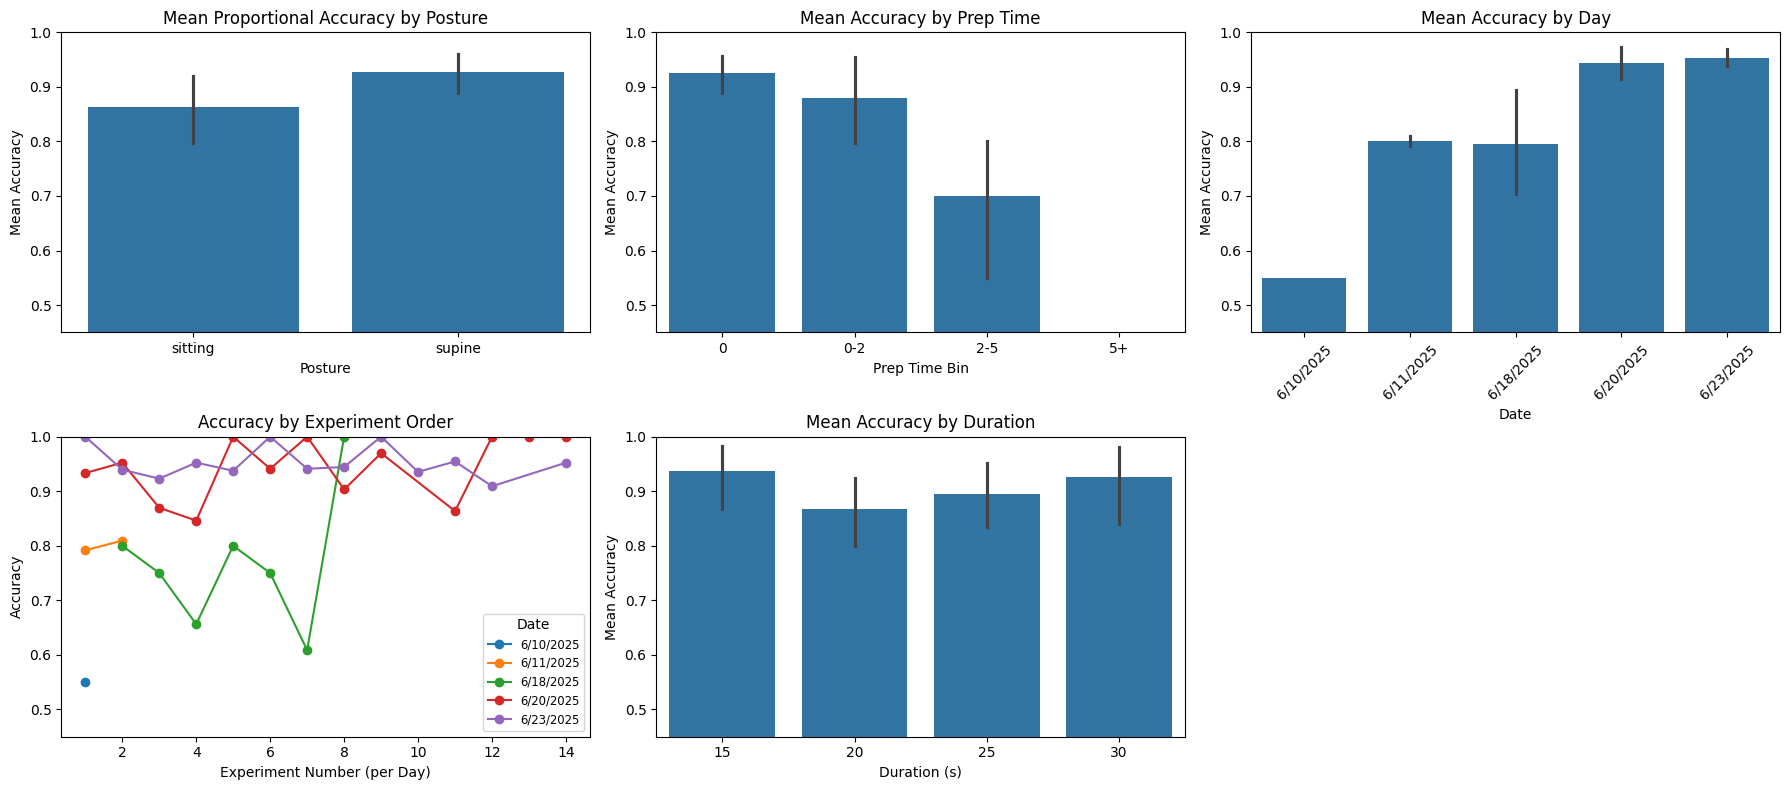

In [30]:
# Prep Bin
df["Prep Bin"] = pd.cut(
    df["Prepatory Period (min)"],
    bins=[-1, 0, 2, 5, 10],
    labels=["0", "0-2", "2-5", "5+"],
)

# Set up subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # So we can index with a single loop

# 1. Accuracy by Posture
sns.barplot(
    data=df, x="Participant Posture", y="Accuracy", estimator=np.mean, ax=axes[0]
)
axes[0].set_title("Mean Proportional Accuracy by Posture")
axes[0].set_ylabel("Mean Accuracy")
axes[0].set_xlabel("Posture")
axes[0].set_ylim(df["Accuracy"].min() - 0.1, 1.0)

# 2. Accuracy by Prep Time
sns.barplot(data=df, x="Prep Bin", y="Accuracy", estimator=np.mean, ax=axes[1])
axes[1].set_title("Mean Accuracy by Prep Time")
axes[1].set_ylabel("Mean Accuracy")
axes[1].set_xlabel("Prep Time Bin")
axes[1].set_ylim(df["Accuracy"].min() - 0.1, 1.0)

# 3. Accuracy by Day
sns.barplot(data=df, x="Date", y="Accuracy", estimator=np.mean, ax=axes[2])
axes[2].set_title("Mean Accuracy by Day")
axes[2].set_ylabel("Mean Accuracy")
axes[2].set_xlabel("Date")
axes[2].set_ylim(df["Accuracy"].min() - 0.1, 1.0)
axes[2].tick_params(axis="x", rotation=45)

# # 4. Accuracy by Experiment Index
# sns.scatterplot(
#     data=df,
#     x="Experiment Index in Day",
#     y="Accuracy",
#     hue="Date",
#     palette="tab10",
#     ax=axes[3],
# )
# axes[3].set_title("Accuracy by Experiment Order")
# axes[3].set_ylabel("Accuracy")
# axes[3].set_xlabel("Experiment Number (per Day)")
# axes[3].set_ylim(df["Accuracy"].min() - 0.1, 1.0)
# axes[3].legend(title="Date", loc="best", fontsize="small")

# 4. Accuracy by Experiment Index (as line plot per Date)
for date, group in df.groupby("Date"):
    sorted_group = group.sort_values("Experiment Index in Day")
    axes[3].plot(
        sorted_group["Experiment Index in Day"],
        sorted_group["Accuracy"],
        marker="o",
        label=date,
    )
axes[3].set_title("Accuracy by Experiment Order")
axes[3].set_ylabel("Accuracy")
axes[3].set_xlabel("Experiment Number (per Day)")
axes[3].set_ylim(df["Accuracy"].min() - 0.1, 1.0)
axes[3].legend(title="Date", loc="best", fontsize="small")

# 5. Accuracy by Duration
sns.barplot(
    data=df,
    x="Duration (s)",
    y="Accuracy",
    estimator=np.mean,
    order=[15, 20, 25, 30],
    ax=axes[4],
)
axes[4].set_title("Mean Accuracy by Duration")
axes[4].set_xlabel("Duration (s)")
axes[4].set_ylabel("Mean Accuracy")
axes[4].set_ylim(df["Accuracy"].min() - 0.1, 1.0)

# Hide unused subplot (6th slot)
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

An initial look at MWs interoceptive accuracy suggests that

- MW is more accurate in a supine posture (this is consistent with the participants narrative report)

- The longer the participant takes to prep the less accurate she tends to be. The narrative reports are also helpful in understanding this trend because she notes that when she's more distracted or can't feel the hearbeat as clearly it takes her a little longer to tune in/prepare. 

- The accuracy of the first day is very low. Narrative reports were not collected this day and experimental notes suggest that the experimenter was working out the kinks of the experimental setup and procedure. Its unclear why the accuracy jumps between the first couple of session and the last ones.

- The order of the experiments doesn't see to matter but with more experiments a trend might emerge.

- Duration is already accounted for in accuracy, so unsurprisingly we don't see a trend here.

## Metacognitive Awareness

Next we examine MWs **metacognitive awareness** (how well confidence aligns with actual accuracy...ie the ability to track one's own performance)

When MW is more or less confident, is she generally more or less off? What does the distribution of error look like given a certain confidence level?

- If higher confidence categories tend to center around zero error (tight box around 0), that suggests that MW knows when she's accurate.
- If lower confidence categories have higher spread or more extreme medians, it suggests MW also knows when she’s less accurate.
- If there’s no trend, or if high-confidence boxes still include large errors, that implies miscalibrated confidence.

In [31]:
confidence_mapping = {"L": 1, "ML": 2, "M": 3, "MH": 4, "H": 5}
df["Confidence Score"] = df["Participant Confidence"].map(confidence_mapping)

In [32]:
valid_data = df.dropna(subset=["Confidence Score", "Accuracy"])
r, p_value = pearsonr(valid_data["Confidence Score"], valid_data["Accuracy"])
print(f"Pearson r = {r:.3f}, p = {p_value:.3g}")

Pearson r = 0.316, p = 0.0567


That result—Pearson r = 0.316, p = 0.0567—suggests a modest positive correlation between participant confidence and accuracy, but it just misses conventional significance (typically p < 0.05). I think with more data it would become clearer/significant. 

Its noteworthy that pearson r looks at graduated correlation but the participant noted if she's really unsure she'll say L, other wise ML, M and MH are all pretty similar but if she's really confident she says H. So an analysis that bins confidence may be a more appropriate model since in this experiment the participant wasn't given specific definitions of what L, M, and H mean so her own definitions for the middle measures (not L, and not H) were variable over the course of many sessions.

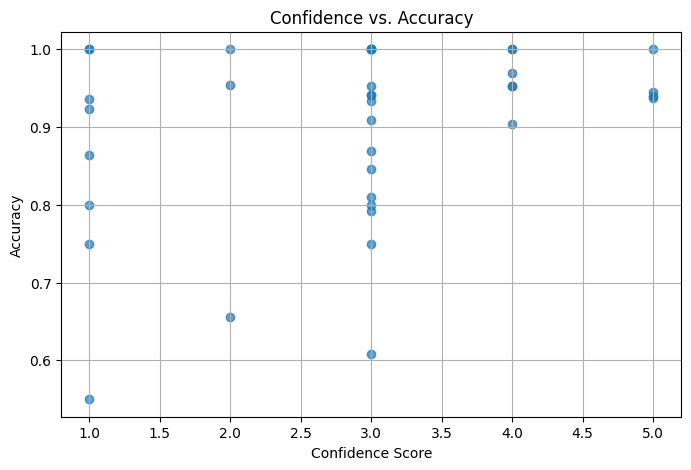

In [33]:
# Plotting Confidence vs. Accuracy
plt.figure(figsize=(8, 5))
plt.scatter(valid_data["Confidence Score"], valid_data["Accuracy"], alpha=0.7)
plt.title("Confidence vs. Accuracy")
plt.xlabel("Confidence Score")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

We can generally see that when the participant's confidence is high she has generally high accuracy but when medium of low it can vary a lot. This is consistent with MWs narrative reports about her method of scoring her confidence.

## Metacognitive Bias

Next we examine **metacognitive bias** (overall tendency to rate high or low)

In [34]:
# Map labels to numeric, if needed, or treat as ordinal
mapping = {"L": 1, "ML": 2, "M": 3, "MH": 4, "H": 5}
df["ConfNum"] = df["Participant Confidence"].map(mapping)

In [35]:
# Calculate bias—mean confidence across trials
mean_conf = df["ConfNum"].mean()
print(f"Overall metacognitive bias (sensibility): {mean_conf:.2f}")

Overall metacognitive bias (sensibility): 2.86


Great so, the mean confidence score of 2.86 (on a 1–5 scale from L to H) suggests a slight underconfidence bias across the dataset since 2.86 is just below the midpoint of 3 (which represents neutral confidence).

Note on interpretation: **Bias ≠ disposition**, especially when trial counts are low and the task is dynamic or experimental.

(While the mean confidence score (2.86) is often interpreted as a measure of metacognitive bias or interoceptive sensibility, it should be viewed with caution in this context. Given that the data come from a limited number of early-stage trials (≈30 across 3 sessions), and that these sessions included variable preparatory periods and evolving experimental setups, the lower average may reflect situational caution or uncertainty rather than a stable tendency toward underconfidence. In this light, the score may be more reflective of task conditions than of trait-level metacognitive bias.)

## Narrative Reports (Storytelling)

Next we examine the narrative "stories" that MW reported after each session where she was asked to talk about or tell the story of what she felt. 

While narrative details have been demonstrated to help the interpretation of quantitative data, we'd like to examine how well narrative story of interoceptive experiences match quantitative data overall. Qualitative data has historically taken a back seat to quantitative data because of its variablility in interpretation and limitations in reading it all. AI, however can be useful in this regard because 1) a static model can be used for consistent interpretation and 2) they can easily read massive amounts of data that would overwhealm human readers.

Therefore, both because interoceptive experiments are notoriously nuanced we wonder what story the narrative data tells as interpreted by a static large langauge model.

In this section of the NB we use LLMs to tell us the story of the participants accuracy against her reported confidence and biases. 

In [36]:
# gather data necessary for narrative examination
# Columns after dropping non-variability columns: ['Date', 'Time (EST)', 'Prepatory Period (min)', 'Participant Posture', 'Duration (s)', 'Participant Count', 'Experimenter Count', 'Participant Confidence', 'Participant Story', 'Experimenter Story', 'Notes', 'Count Difference', 'Accuracy', 'Experiment Index in Day']

# gather data to send to GPT (may need to batch if number of rows is too large)
df_subset2 = df.reset_index(names="index")[
    ["index", "Participant Story", "Experimenter Story", "Notes", "Accuracy"]
]
data_to_send2 = df_subset2.to_dict(orient="records")
narrative_data_json = json.dumps(data_to_send2)

In [39]:
system_msg2 = (
    "You are analyzing narrative reports from a heartbeat tracking experiment.\n\n"
    "Each row contains a participant's subjective report, the experimenter's observations, notes, and the measured accuracy.\n\n"
    "Your job is to read these narrative accounts carefully and extract insights that are not captured in the accuracy score.\n\n"
    "Return a structured list of noteworthy points that can help researchers:\n"
    "1. Improve the experimental design or setup.\n"
    "2. Understand how participants interpret the task or stimuli.\n"
    "3. Identify variables that influenced perception, performance, or self-reporting.\n"
    "4. Recognize signs of participant strengths, difficulties, biases, or confusion.\n"
    "5. Detect issues or uncertainties on the experimenter’s end (e.g., low confidence, imprecise timing, distractions).\n\n"
    "For each noteworthy row, include:\n"
    "- The index of the row.\n"
    "- A short summary of what was found (e.g., 'participant confused about task', 'external distraction noted by experimenter').\n"
    "- Whether the insight pertains to the participant, the experimenter, or the experimental setup.\n\n"
    "Use your judgment to prioritize:\n"
    "- Reports of confusion, self-doubt, or reinterpretation.\n"
    "- Mentions of external influences (noises, timing, bodily sensations, etc).\n"
    "- Experimenter observations that indicate uncertainty or possible procedural inconsistencies.\n\n"
    "Be careful not to overinterpret. Focus only on what is clearly or strongly suggested by the text.\n"
)

user_msg2 = f"Here is the data:\n{narrative_data_json}\n\n"

In [40]:
completion = client.chat.completions.create(
    model="openai/gpt-4.1-nano",
    messages=[
        {"role": "system", "content": system_msg2},
        {"role": "user", "content": user_msg2},
    ],
    temperature=0,
)

result = completion.choices[0].message.content.strip()
print(result)

# Optional: attempt to parse the response
try:
    flagged_indices = eval(result)
except Exception as e:
    print("Failed to parse response:", e)
    flagged_indices = []

print("Narrative Analysis:", flagged_indices)

1. Index 0  
   - Participant struggled to differentiate heartbeat from other bodily sensations.  
   - *Insight:* Participants may have difficulty distinguishing heartbeat sensations from other internal cues, suggesting a need for clearer instructions or training on what sensations to focus on. (Participant)

2. Index 1  
   - Participant may have started counting at 4 instead of 1.  
   - *Insight:* Participants might misinterpret cues for when to start, indicating the importance of explicit timing instructions or practice trials. (Participant)

3. Index 2  
   - Participant did not consistently start and stop at verbal cues.  
   - *Insight:* External cues may not be sufficiently salient or participants may need more guidance on cue timing. (Participant)

4. Index 3  
   - Participant felt unsure about feeling their heartbeat, describing it as faint, but experimenter noted the heartbeat was stronger than perceived.  
   - *Insight:* Participants' subjective perception of heartbeat s

Narrative analysis not only returns the same thing each time (per same prompt) but is able pick up on key things of value...

- Starting/stopping synchrony can be difficult
- Performing experiments at the same time of day with the same bodily state is helpful (eg. not post meal)
- Participant focus affects accuracy, focus can be trained and vary day to day
- Heartbeat changes amplitude and location prominently felt
- Confidence reports fall into 2 bins (very high, not)
- Participant can learn strategies over time

With more detailed prompts/questions the a static model can provide more insights like examing how well narrative confidence interpretation reflcts the one quantiatively measured, etc.

# Supplementary Materials

## Background: Interoception and the Heartbeat Tracking Task

Interoception refers to the sensing, interpretation, and integration of internal bodily signals, including heartbeat, respiration, and visceral cues. It plays a key role in emotional experience, self-awareness, and decision-making. Recent research has moved beyond simple accuracy measures to a multidimensional model of interoception, encompassing:
- Interoceptive Accuracy: Objective performance on interoceptive tasks (e.g., how closely heartbeat counts match actual heartbeats).
- Interoceptive Awareness: Metacognitive insight—how well one’s confidence tracks actual performance.
- Interoceptive Bias or Sensibility: Subjective self-report of interoceptive ability, often derived from confidence ratings or questionnaires.

This tripartite distinction (Garfinkel et al., 2015) has helped clarify inconsistencies in earlier interoception studies by distinguishing what people feel, what they think they feel, and how well they know what they feel.

### The Heartbeat Tracking Task

A widely used method to assess cardiac interoception is the heartbeat tracking (or counting) task, in which participants silently count their perceived heartbeats over timed intervals without manually checking their pulse. Performance is scored by comparing the reported count to actual heartbeats (measured via ECG or pulse monitor), producing a proportional accuracy metric.

The task has been used in healthy populations and clinical studies, but has been criticized for:
- Susceptibility to non-interoceptive strategies (e.g., time estimation).
- Variability based on trial duration, breathing, and physical state.
- Influence of prior expectations or beliefs about heart rate.

Nonetheless, when used cautiously and paired with confidence ratings, it remains a valuable tool to study interoceptive processes.

## Materials Required
- Blindfold  
- Stopwatch
- Spreadsheet

## Indicator Code/Protocol

Participants use taps or clicks to communicate during the experiment using the following code:

| Tap Pattern | Meaning            |
|-------------|--------------------|
| `-`         | Start / Yes / Low  |
| `- -`       | Stop / No / Medium |
| `- - -`     | High               |
| `- - ... -` | Reset              |

This nonverbal signaling method is intended to minimize disturbance during interoceptive focus.

## Experimenter Script

This script is designed to be read or followed by the experimenter during the protocol. Spoken lines are in **bold quotes**, and internal actions or notes are in _italics_.

---

### Experiment

1. **"Indicate when you feel ready to begin the (mock) experiment (by giving one tap)."**  
   _Wait for participant's `-` tap._

2. **"Get ready... and start."**  
   _Begin silent count for 15–30 seconds (use stopwatch)._

3. _At the end of the interval:_  
   **"Stop. How many heartbeats did you count?"**
   _Record participant's spoken response._  
   _Record actual heartbeat count (from device)._  

4. **"How confident are you in your count? Please tap once for low confidence, twice for medium, or three times for high confidence."**
   _Record participant's tap response._
   _Record any additional notes._

7. **"Okay, that completes this experiment."**  
   _Repeat mock or real experiments._

---